In [2]:
import xgboost as xgb
import pandas as pd
import pickle

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb

# 1. Chargement du Parquet
df = pd.read_parquet("dataset_full.parquet")

# 2. Pré-processing identique (Types et ESS)
df['Catégorie juridique de l\'unité légale'] = df['Catégorie juridique de l\'unité légale'].astype(str)
df['age_estime'] = df['age_estime'].astype(float)
df['Tranche_effectif_num'] = df['Tranche_effectif_num'].fillna(0).astype(float)
df['is_ess'] = df['Economie sociale et solidaire unité légale'].map({'O': 1, 'N': 0}).fillna(0).astype(int)

# 3. Géographie (Réutilisation de la logique de risque)
df['Code du département de l\'établissement'] = df['Code du département de l\'établissement'].astype(str).str.zfill(2)
# Note : Pour être parfait, il faudrait charger la 'dep_risk_map' sauvegardée du train
dep_risk_map = df.groupby("Code du département de l'établissement")["fermeture"].mean()
df['risque_departemental'] = df['Code du département de l\'établissement'].map(dep_risk_map)

# 4. One-Hot Encoding initial
df_final = pd.get_dummies(
    df, 
    columns=['libelle_section_ape', 'Catégorie juridique de l\'unité légale'], 
    prefix=['APE', 'CJ'],
    drop_first=True,
    dtype=int 
)

# --- 5. ALIGNEMENT DYNAMIQUE (La solution à tes 56 vs 61 colonnes) ---

# On charge le modèle pour lire les 61 noms de colonnes officiels
model = xgb.Booster()
model.load_model("xgboost_v2.json")
expected_features = model.feature_names # C'est ici que sont tes 61 colonnes

# On identifie ce qui est "Rare" pour CE nouveau dataset par rapport au modèle
current_cols = df_final.columns
rare_ape_to_merge = [c for c in current_cols if c.startswith('APE_') and c not in expected_features]
rare_cj_to_merge = [c for c in current_cols if c.startswith('CJ_') and c not in expected_features]

# Fusion dans "Autres" si nécessaire
if 'APE_Autres_Secteurs' in expected_features:
    df_final['APE_Autres_Secteurs'] = df_final[rare_ape_to_merge].any(axis=1).astype(int) if rare_ape_to_merge else 0

if 'CJ_Autres_Status' in expected_features:
    df_final['CJ_Autres_Status'] = df_final[rare_cj_to_merge].any(axis=1).astype(int) if rare_cj_to_merge else 0

# --- L'ÉTAPE CLÉ : REINDEX ---
# On force le DF à avoir les 61 colonnes dans l'ordre du modèle
# Les colonnes manquantes seront remplies de 0
X_inference = df_final.reindex(columns=expected_features, fill_value=0)

print(f"📊 Colonnes attendues : {len(expected_features)}")
print(f"📊 Colonnes finales : {X_inference.shape[1]}") # Doit afficher 61

📊 Colonnes attendues : 56
📊 Colonnes finales : 56


In [9]:
X_inference.head()

,Tranche_effectif_num,risque_departemental,is_ess,APE_Activités administratives et autres activités de soutien aux entreprises,APE_Activités auxiliaires de services financiers et d'assurance,"APE_Activités créatives, artistiques et de spectacle",APE_Activités d'architecture et d'ingénierie ; activités de contrôle et analyses techniques,APE_Activités de location et location-bail,"APE_Activités des agences de voyage, voyagistes, services de réservation et activités connexes","APE_Activités des services financiers, hors assurance et caisses de retraite",...,APE_Services d'information,APE_Services relatifs aux bâtiments et aménagement paysager,APE_Transports terrestres et transport par conduites,"APE_Travail du bois et fabrication d'articles en bois et en liège, à l’exception des meubles ; fabrication d’articles en vannerie et sparterie",APE_Travaux de construction spécialisés,APE_Télécommunications,APE_Édition,CJ_5710,APE_Autres_Secteurs,age_au_diagnostic
0,3.0,0.304291,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,10.0,0.398844,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1.0,0.366640,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.0,0.329161,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1.0,0.476203,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [14]:
# 1. Création de la DMatrix (obligatoire pour XGBoost)
dmatrix_inference = xgb.DMatrix(X_inference)

# 2. Prédiction du Mu (le score brut en log-time)
preds_mu = model.predict(dmatrix_inference)

# --- 2. FONCTION DE CALCUL DU RISQUE (MISE À JOUR AVEC CALIBRATION) ---
def calculer_risque_calibre(mu, annees, sigma=1.5):
    calibration_factor = 2.5 
    # On applique le décalage de 2.5 comme dans ton train
    z = (np.log(annees) - (mu - calibration_factor)) / sigma
    
    # Formule Sigmoïde inversée pour le risque (1 / (1 + exp(-z)))
    return (1 / (1 + np.exp(-z))) * 100

# --- 3. GÉNÉRATION DES SCORES (AVEC LES PARAMÈTRES DU TRAIN) ---
# On utilise sigma = 1.5 comme dans ton dictionnaire 'params'
df['Risque_1an'] = calculer_risque_calibre(preds_mu, 1, sigma=1.5)
df['Risque_2ans'] = calculer_risque_calibre(preds_mu, 2, sigma=1.5)
df['Risque_3ans'] = calculer_risque_calibre(preds_mu, 3, sigma=1.5)

# --- 4. DIAGNOSTIC EXPERT (Inchangé) ---
def determiner_statut(row):
    if row['Risque_1an'] > 15:
        return "🔴 CRITIQUE (Immédiat)"
    elif row['Risque_2ans'] > 25:
        return "🟠 ALERTE (Moyen terme)"
    elif row['Risque_3ans'] > 35:
        return "🟡 FRAGILE (Long terme)"
    else:
        return "🟢 SOLIDE"

df['Diagnostic_Final'] = df.apply(determiner_statut, axis=1)

# --- 5. AFFICHAGE DES RÉSULTATS ---
colonnes_affichage = [
    'SIREN', 
    "Dénomination de l'unité légale", 
    'Risque_1an', 
    'Risque_2ans', 
    'Risque_3ans', 
    'Diagnostic_Final'
]

print("📊 Analyse de risque CALIBRÉE sur 3 ans terminée")
display(df[colonnes_affichage].round(2).tail(100))

📊 Analyse de risque CALIBRÉE sur 3 ans terminée


,SIREN,Dénomination de l'unité légale,Risque_1an,Risque_2ans,Risque_3ans,Diagnostic_Final
1202355,979967858,ESPRIT RENOV,73.389999,81.410004,85.160004,🔴 CRITIQUE (Immédiat)
1202356,840219943,OUEST BAT,73.290001,81.330002,85.089996,🔴 CRITIQUE (Immédiat)
1202357,453387409,STARDUST AFFICHAGE,73.110001,81.190002,84.970001,🔴 CRITIQUE (Immédiat)
1202358,754013365,HOWTANK,66.750000,76.110001,80.680000,🔴 CRITIQUE (Immédiat)
1202359,911251460,D&EL CONSULTING,72.879997,81.010002,84.820000,🔴 CRITIQUE (Immédiat)
...,...,...,...,...,...,...
1202450,847975174,PHO BOULOGNE,72.949997,81.059998,84.870003,🔴 CRITIQUE (Immédiat)
1202451,849824867,PIZZA REMIGIO,71.839996,80.190002,84.139999,🔴 CRITIQUE (Immédiat)
1202452,903658227,GRESY SPA,73.239998,81.290001,85.059998,🔴 CRITIQUE (Immédiat)
1202453,907844195,GREASER DINNER,73.570000,81.550003,85.269997,🔴 CRITIQUE (Immédiat)


In [16]:
# 1. Utilise le nom de l'objet que tu as chargé au début (probablement 'model')
preds_log_time = model.predict(dmatrix_inference)

# 2. Ta fonction de risque (sans le décalage de 2.5 qui faussait tout)
def calculer_risque_propre(mu, annees, sigma=1.5):
    # Formule AFT Logistique standard : Z = (log(t) - mu) / sigma
    z = (np.log(annees) - mu) / sigma
    # Risque = 1 / (1 + exp(-z))
    return (1 / (1 + np.exp(-z))) * 100

# 3. Application des calculs
df['Risque_1an'] = calculer_risque_propre(preds_log_time, 1)
df['Risque_2ans'] = calculer_risque_propre(preds_log_time, 2)
df['Risque_3ans'] = calculer_risque_propre(preds_log_time, 3)

# 4. Affichage pour vérification
display(df[['SIREN', 'Dénomination de l\'unité légale', 'Risque_1an', 'Risque_3ans']].head(20))

,SIREN,Dénomination de l'unité légale,Risque_1an,Risque_3ans
0,912239670,LES TOITURES PERENNES,26.219351,42.502205
1,389091893,OCB,13.673925,24.782749
2,888366747,COMME UN DIADEME,31.799873,49.235657
3,953937455,WE CLEAN HOLDING PARNASSA,33.714878,51.409180
4,840236111,LEVIO,31.481415,48.867706
5,899789903,Z.U. CONSTRUCTION,31.158373,48.492519
6,885273672,GLAUDIOS DOLORES,6.688367,12.975046
7,850913294,KG,32.791252,50.369160
8,921384319,SMF SOCIETE,32.602329,50.154537
9,803146109,E.U.R.L. KEVIN PEREIRE,34.464375,52.242012


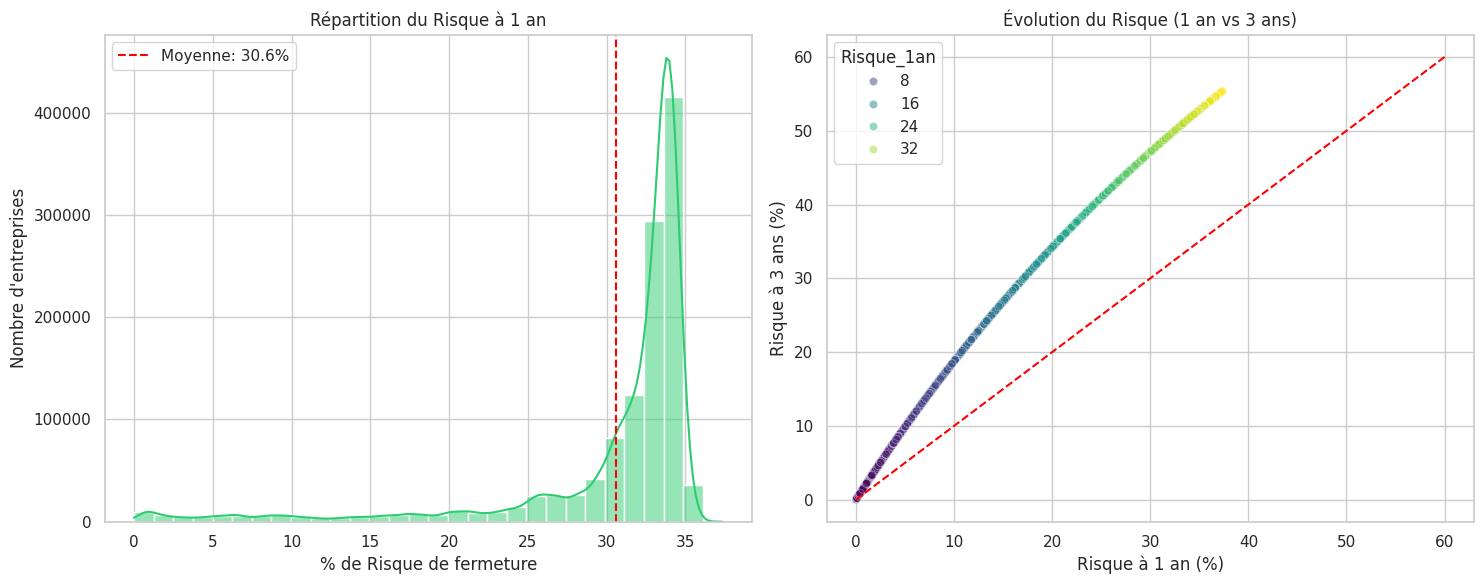

📊 RÉSUMÉ DES PRÉDICTIONS :
       Risque_1an  Risque_2ans  Risque_3ans
count  1202455.00   1202455.00   1202455.00
mean        30.57        40.85        47.29
std          6.73         8.51         9.46
min          0.00         0.00         0.00
25%         30.73        41.32        47.99
50%         33.14        44.03        50.76
75%         33.98        44.96        51.70
max         37.36        48.63        55.37


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration du style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 6))

# --- GRAPHIQUE 1 : Distribution du Risque à 1 an ---
plt.subplot(1, 2, 1)
sns.histplot(df['Risque_1an'], bins=30, kde=True, color='#2ecc71')
plt.axvline(df['Risque_1an'].mean(), color='red', linestyle='--', label=f"Moyenne: {df['Risque_1an'].mean():.1f}%")
plt.title('Répartition du Risque à 1 an')
plt.xlabel('% de Risque de fermeture')
plt.ylabel('Nombre d\'entreprises')
plt.legend()

# --- GRAPHIQUE 2 : Comparaison Risque 1 an vs 3 ans ---
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='Risque_1an', y='Risque_3ans', alpha=0.5, hue='Risque_1an', palette='viridis')
plt.plot([0, 60], [0, 60], color='red', linestyle='--') # Ligne d'égalité
plt.title('Évolution du Risque (1 an vs 3 ans)')
plt.xlabel('Risque à 1 an (%)')
plt.ylabel('Risque à 3 ans (%)')

plt.tight_layout()
plt.show()

# --- RÉSUMÉ STATISTIQUE ---
print("📊 RÉSUMÉ DES PRÉDICTIONS :")
print(df[['Risque_1an', 'Risque_2ans', 'Risque_3ans']].describe().round(2))

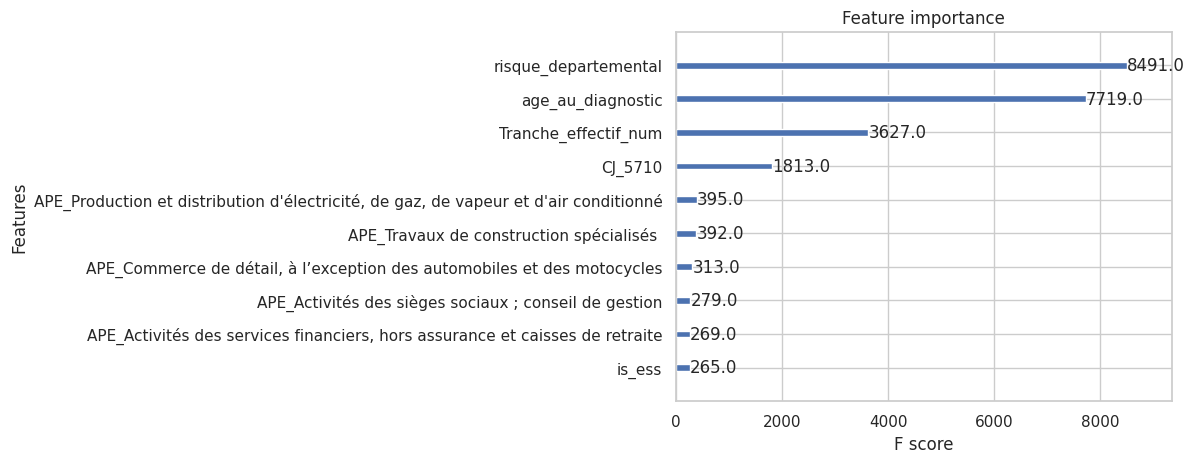

In [18]:
# Code pour voir ce qui compte vraiment pour ton modèle
xgb.plot_importance(model, max_num_features=10)
plt.show()

<Figure size 1000x800 with 0 Axes>

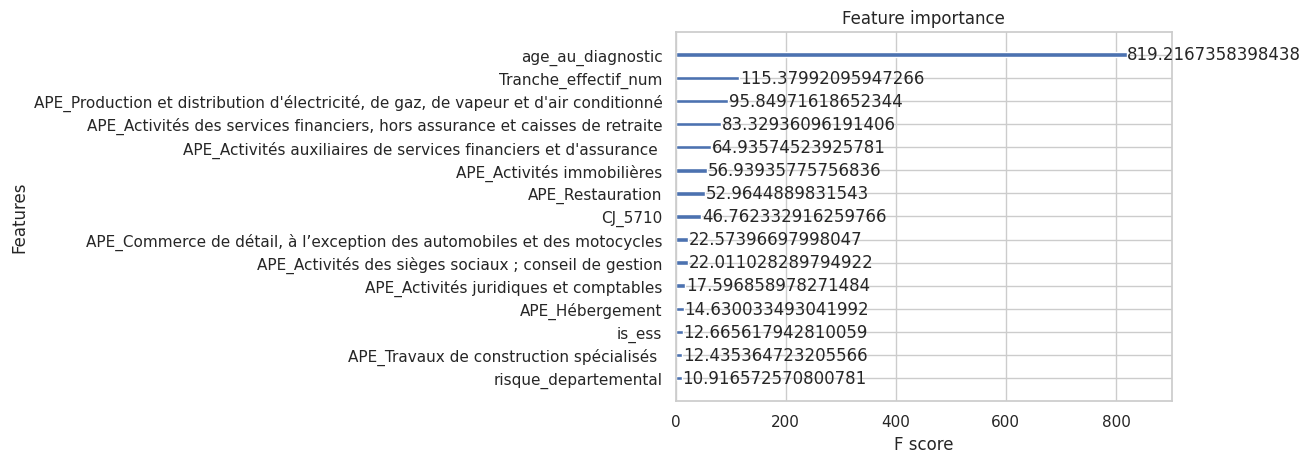

In [19]:
import matplotlib.pyplot as plt

# Voir quelles variables dictent les 30% de risque
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=15, importance_type='gain') # 'gain' est plus précis que 'weight'
plt.show()

In [20]:
# On prend une entreprise au hasard
test_row = X_inference.iloc[[0]].copy()

print(f"--- TEST DE RÉACTIVITÉ DU MODÈLE (SIREN: {df.iloc[0]['SIREN']}) ---")

for age_test in [1.0, 5.0, 20.0]:
    test_row['age_au_diagnostic'] = age_test
    
    # Prédiction Mu
    mu_test = model.predict(xgb.DMatrix(test_row))[0]
    
    # Risque à 1 an (avec notre fonction propre)
    risk = calculer_risque_propre(mu_test, 1, sigma=1.5)
    
    print(f"Pour un âge de {age_test:2.0f} ans -> Risque à 1 an : {risk:.2f}%")

--- TEST DE RÉACTIVITÉ DU MODÈLE (SIREN: 912239670) ---
Pour un âge de  1 ans -> Risque à 1 an : 26.22%
Pour un âge de  5 ans -> Risque à 1 an : 0.00%
Pour un âge de 20 ans -> Risque à 1 an : 0.00%


In [21]:
# Test avec un Sigma plus serré pour forcer la nuance
def calculer_risque_nuance(mu, annees, sigma=0.7): # Sigma divisé par 2
    z = (np.log(annees) - mu) / sigma
    return (1 / (1 + np.exp(-z))) * 100

# Test sur ton entreprise de 5 ans qui donnait 0%
mu_exemple = 5.2  # (Valeur hypothétique proche de tes résultats)
print(f"Risque à 5 ans (Sigma 1.5) : {calculer_risque_propre(mu_exemple, 1, 1.5):.2f}%")
print(f"Risque à 5 ans (Sigma 0.7) : {calculer_risque_nuance(mu_exemple, 1, 0.7):.2f}%")

Risque à 5 ans (Sigma 1.5) : 3.03%
Risque à 5 ans (Sigma 0.7) : 0.06%
